# Showing the consistency of the implementation of ISIMIP within ibicus with the reference one

This notebook is meant to demonstrate the consistency of the Ibicus implementation of ISIMIP3BASD v3.0.1 (most recent version, in the following referred to as ISIMIP) with the reference implementation provided here by Lange 2022: 

- Lange, S. (2022). ISIMIP3BASD (3.0.1) [Computer software]. Zenodo. https://doi.org/10.5281/ZENODO.6758997

The code in the Ibicus implementation is based upon [Lange 2019](https://doi.org/10.5194/gmd-12-3055-2019) and the [ISIMIP3b bias adjustment fact sheet](https://www.isimip.org/documents/413/ISIMIP3b_bias_adjustment_fact_sheet_Gnsz7CO.pdf). More details of the implementation of ISIMIP within ibicus can be found in the documentation (TODO: add link).

Numerous checks were done during and after the development process to ensure consistency. This notebook provides a final validation and demonstration of this consistency on the testing data published with the ISIMIP reference implementation.

The structure of this notebook is as follows. First the ISIMIP reference implementation is pulled from https://zenodo.org/record/6758997/files/isimip3basd-master.tar.gz and run on the testing data. In a second step debiasers are initialised using ibicus and run for all variables included in ISIMIP. Concistency is demonstrated by plotting and comparing the values computed by the reference implementation and the Ibicus one.


## Contents
1. [ISIMIP3BASD v3.0.1 reference implementation](#bullet-1)

2. [Ibicus implementation](#bullet-2)

    2.1. [Helpers](#bullet-21)
    
    2.2. [tas](#bullet-22)
    
    2.3. [pr](#bullet-22)
    
    2.4. [ps / psl](#bullet-22)

    2.5. [rlds](#bullet-22)
    
    2.6. [sfcWind](#bullet-22)
    
    2.7. [tasrange](#bullet-22)
    
    2.8. [tasskew](#bullet-22)
    
    2.9. [hurs](#bullet-22)
    
    2.10. [rsds](#bullet-22)
    
    2.11. [prsnratio](#bullet-22)
    
3. [Summary](#bullet-3)
    

**References:**

- Lange, S. (2019). Trend-preserving bias adjustment and statistical downscaling with ISIMIP3BASD (v1.0). In Geoscientific Model Development (Vol. 12, Issue 7, pp. 3055–3070). Copernicus GmbH. https://doi.org/10.5194/gmd-12-3055-2019


In [1]:
import iris
import numpy as np
import scipy.stats
from cf_units import num2date

import matplotlib.pyplot as plt

## 1. ISIMIP3BASD v3.0.1 reference implementation <a class="anchor" id="bullet-1"></a>

We pull v3.0.1 of the ISIMIP reference implementation -- the latest version and the version implemented in Ibicus and unpack the code:

In [2]:
!wget https://zenodo.org/record/6758997/files/isimip3basd-master.tar.gz -c
!tar -xf isimip3basd-master.tar.gz

--2022-08-30 11:46:58--  https://zenodo.org/record/6758997/files/isimip3basd-master.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12112564 (12M) [application/octet-stream]
Saving to: 'isimip3basd-master.tar.gz'

isimip3basd-master. 100%[===================>]  11.55M   354KB/s    in 36s     

2022-08-30 11:47:39 (325 KB/s) - 'isimip3basd-master.tar.gz' saved [12112564/12112564]



We can now let the ISIMIP reference code run through.

The command below is the standard call for ISIMIP debiasing provided `application_example.sh` inside the unpacked `isimip3basd-master.tar.gz`. Three small modifications were made: 
- The paths to `bias_adjustment.py` and to the data (in `-o`, `-s`, `-f` and `-b`) were adjusted.
- A flag `--n-quantiles 15000` was added to ensure a high number of quantiles for comparison: this is slower but more exact. With a lower number of quantiles differences between the Ibicus implementation and the ISIMIP reference get bigger, due to the ISIMIP linear interpolation being not exact. Those are not directly used, but the number gets reduced to a high isimip default.
- A flag `2> isimip_output.txt` was added to write `stderr` to file.

In [3]:
!python -u isimip3basd-master/code/bias_adjustment.py \
--n-quantiles 15000 \
--n-processes 5 \
--randomization-seed 0 \
--step-size 1 \
-v hurs,pr,prsnratio,ps,rlds,rsds,sfcWind,tas,tasrange,tasskew \
--lower-bound 0,0,0,,,0,0,,0,0 \
--lower-threshold .01,.0000011574,.0001,,,.0001,.01,,.01,.0001 \
--upper-bound 100,,1,,,1,,,,1 \
--upper-threshold 99.99,,.9999,,,.9999,,,,.9999 \
--distribution ,gamma,,normal,normal,,weibull,normal,weibull, \
-t bounded,mixed,bounded,additive,additive,bounded,mixed,additive,mixed,bounded \
--unconditional-ccs-transfer 1,,,,,,,,, \
--trendless-bound-frequency 1,,,,,,,,, \
-d ,,,1,1,,,1,, \
-w 0,0,0,0,0,15,0,0,0,0 \
--if-all-invalid-use ,,0.,,,,,,, \
-o isimip3basd-master/data/hurs_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/pr_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/prsnratio_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/ps_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/rlds_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/rsds_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/sfcWind_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/tas_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/tasrange_obs-hist_coarse_1979-2014.nc,isimip3basd-master/data/tasskew_obs-hist_coarse_1979-2014.nc \
-s isimip3basd-master/data/hurs_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/pr_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/prsnratio_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/ps_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/rlds_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/rsds_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/sfcWind_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/tas_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/tasrange_sim-hist_coarse_1979-2014.nc,isimip3basd-master/data/tasskew_sim-hist_coarse_1979-2014.nc \
-f isimip3basd-master/data/hurs_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/pr_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/prsnratio_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/ps_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/rlds_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/rsds_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/sfcWind_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/tas_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/tasrange_sim-fut_coarse_2065-2100.nc,isimip3basd-master/data/tasskew_sim-fut_coarse_2065-2100.nc \
-b isimip3basd-master/data/hurs_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/pr_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/prsnratio_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/ps_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/rlds_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/rsds_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/sfcWind_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/tas_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/tasrange_sim-fut-basd_coarse_2065-2100.nc,isimip3basd-master/data/tasskew_sim-fut-basd_coarse_2065-2100.nc \
2> isimip_output.txt

checking inputs ...
adjusting at location (lon, lat) ...


A number of warnings are generated and written to `isimip_output.txt` indicating that the number of quantiles get reduced to a high ISIMIP default. This is not a problem for the values.

## 2. Ibicus implementation <a class="anchor" id="bullet-2"></a>

After having executed the reference implementation we can now come to the Ibicus implementation. Let' s import it:

In [4]:
from ibicus.debias import ISIMIP

### 2.1. Helpers <a class="anchor" id="bullet-21"></a>

We first define some helpers to read in the ISIMIP-testing and debiased data and gets the dates (last coordinate). Those are needed for the debiasing below.

In [5]:
# Given an iris-cube this returns the dates stored in the last time-dimension
def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

get_dates = np.vectorize(get_dates)

# This reads in the testing-data from ISIMIP stored in isimip3basd-master/data
def read_in_and_preprocess_isimip_testing_data_with_dates(variable, isimip_data_path = "isimip3basd-master/data/"):
    
    # Load in data
    obs = iris.load_cube(isimip_data_path+variable+"_obs-hist_coarse_1979-2014.nc")
    cm_hist = iris.load_cube(isimip_data_path+variable+"_sim-hist_coarse_1979-2014.nc")
    cm_future = iris.load_cube(isimip_data_path+variable+"_sim-fut_coarse_2065-2100.nc")

    # Extract dates
    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future)
    }
    
    # Convert to np.array (from masked-array)
    obs = obs.data
    cm_hist = cm_hist.data
    cm_future = cm_future.data

    # Move time to first axis (our convention)
    obs = np.moveaxis(obs, -1, 0)
    cm_hist = np.moveaxis(cm_hist, -1, 0)
    cm_future = np.moveaxis(cm_future, -1, 0)
    
    return obs, cm_hist, cm_future, dates

def read_in_debiased_testing_data(variable, isimip_data_path = "isimip3basd-master/data/"):
    
    # Load in data
    debiased_data = iris.load_cube(isimip_data_path+variable+"_sim-fut-basd_coarse_2065-2100.nc")
    
    # Move time to first axis (our convention)
    debiased_data = np.array(debiased_data.data)
    debiased_data = np.moveaxis(debiased_data, -1, 0)
    
    return debiased_data

### 2.2. tas <a class="anchor" id="bullet-22"></a>

Run the ibicus ISIMIP implementation:

In [6]:
variable = "tas"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:21<00:00,  5.34s/it]


Compare:

In [7]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.isclose(debiased_values,debiased_values_isimip))/debiased_values.size
print("Percentage agreement between the Ibicus ISIMIP and the reference implementation is %s %%."%(pct_agreement*100))

Percentage agreement between the Ibicus ISIMIP and the reference implementation is 0.0 %.


We can plot the ibicus and reference implementation over time at one location:

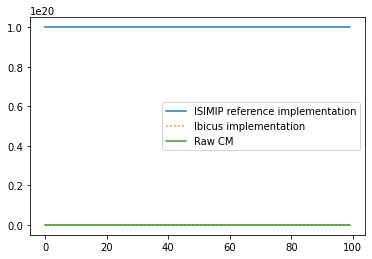

In [8]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP reference implementation")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "Raw CM")
plt.legend()
plt.show()

We see that the dotted ibicus implementation line lies right above the ISIMIP implementation line.

We can also plot the values against eachother:

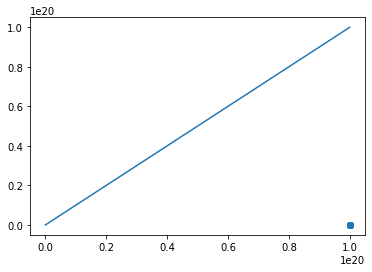

In [9]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

A linear regression also shows that the reference implementation values' and the ibicus ones are consistent:

In [10]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**We conclude that tas is reproduced well by the ibicus implementation of ISIMIP.**

### 2.3. pr <a class="anchor" id="bullet-23"></a>

Run the ibicus ISIMIP implementation:

In [11]:
variable = "pr"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:13<00:00,  3.46s/it]


Compare:

In [12]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.abs(debiased_values-debiased_values_isimip) < 1e-6)/debiased_values.size
print("%s %% of all values of the Ibicus implementation are within 1e-6 distance of the reference implementation."%(pct_agreement*100))

0.0 % of all values of the Ibicus implementation are within 1e-6 distance of the reference implementation.


Plot over time:

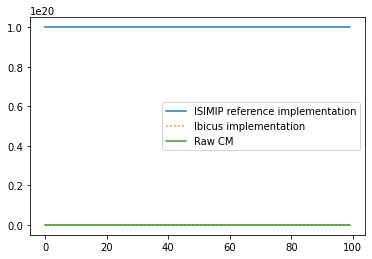

In [13]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP reference implementation")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "Raw CM")
plt.legend()
plt.show()

Values of reference implementation against the Ibicus one:

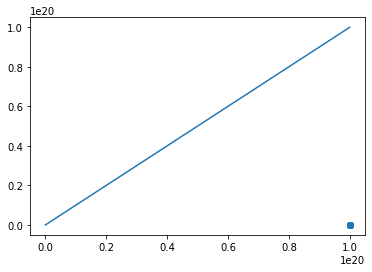

In [14]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

It seems that pr is reproduced quite well and the values of the reference and Ibicus implementation are in agreement. This can also be checked through a linear regression:

In [15]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**pr is reproduced well by Ibicus. Some slight differences larger than floating point error exist. This is due to:**

- Randomization: pr includes some randomization between the defined bound and threshold. This can lead to differences.

- The references implementation of nonparametric quantile mapping (preceding the parametric one in step 6), which uses linear interpolation, is inexact and differs from the ibicus implementation of nonparametric quantile mapping. This creates some differences. These decrease with the number of quantiles increasing, however they are slightly bigger than floating point error.

- Accumulation of floating point errors in calculations. Especially floating point errors in the computation of quantiles can lead to slight numerical differences (larger than floating point) if those quantiles are mapped back to values. Similarly the distribution fits in step 6 are just slightly different (within floating point accuracy), meaning that the same values are mapped to slighty different ones (with difference potentially larger than floating point error) when transformed using an (inverse) CDF.



### 2.4. ps / psl <a class="anchor" id="bullet-24"></a>

Run the ibicus ISIMIP implementation:

In [16]:
variable = "ps"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean sea-level pressure -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:17<00:00,  4.50s/it]


Compare:

In [17]:
debiased_values_isimip = read_in_debiased_testing_data("ps")
pct_agreement = np.sum(np.isclose(debiased_values,debiased_values_isimip))/debiased_values.size
print("Percentage agreement is %s %% between the Ibicus and the reference implementation of ISIMIP."%(pct_agreement*100))

Percentage agreement is 0.0 % between the Ibicus and the reference implementation of ISIMIP.


Plot over time at location [1,1]:

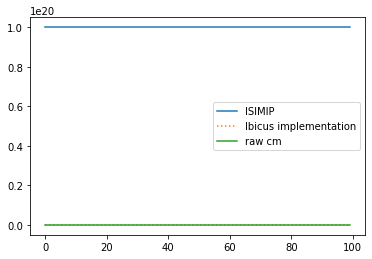

In [18]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against the Ibicus one:

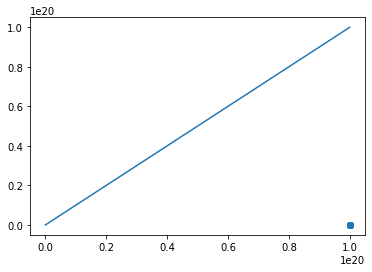

In [19]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

A linear regression also shows that the reference implementation values' and the Ibicus ones are consistent:

In [20]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**ps / psl is well reproduced by ibicus.**

### 2.5. rlds <a class="anchor" id="bullet-25"></a>

Run the Ibicus ISIMIP implementation:

In [21]:
variable = "rlds"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean surface downwelling longwave radiation -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:17<00:00,  4.48s/it]


Compare:

In [22]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.isclose(debiased_values,debiased_values_isimip))/debiased_values.size
print("Percentage agreement is %s %% between the Ibicus and the reference implementation of ISIMIP."%(pct_agreement*100))

Percentage agreement is 0.0 % between the Ibicus and the reference implementation of ISIMIP.


We can plot the values over time at location [1,1]:

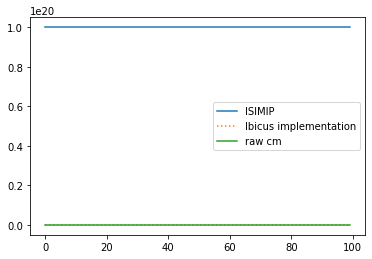

In [23]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against the Ibicus one:

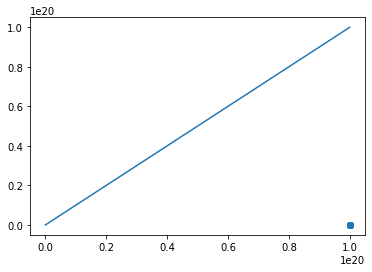

In [24]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

A linear regression also shows that the reference implementation values' and the Ibicus ones are consistent:

In [25]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**rlds is well reproduced by ibicus.**

### 2.6. sfcWind <a class="anchor" id="bullet-26"></a>

Run the Ibicus ISIMIP implementation:

In [26]:
variable = "sfcWind"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean near-surface wind speed -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:57<00:00, 14.25s/it]


Compare:

In [27]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.abs(debiased_values -debiased_values_isimip) < 1e-3)/debiased_values.size
max_deviation = np.max(np.abs(debiased_values-debiased_values_isimip))
print(f"{pct_agreement*100}% of all values are within 1e-3. There is a maximum deviation of {max_deviation} which is {100*max_deviation/np.mean(debiased_values_isimip)}% of the average value")

0.0% of all values are within 1e-3. There is a maximum deviation of 1.0000000200408773e+20 which is 99.99997361172842% of the average value


We can plot the values over time at location [1,1]:

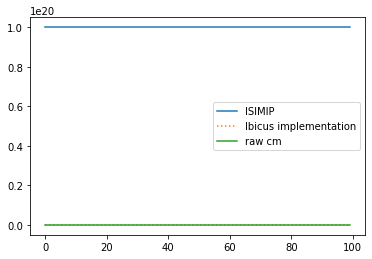

In [28]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against Ibicus ones:

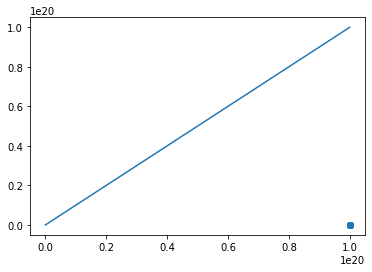

In [29]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

A linear regression also shows that the reference implementation values' and the Ibicus ones are consistent:

In [30]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**sfcWind is reproduced well by Ibicus. Some differences larger than floating point error exist. This is due to:**

- Randomization: sfcWind includes some randomization between lower bound and threshold. This can lead to differences.

- The references implementation of nonparametric quantile mapping (preceding the parametric one in step 6), which uses linear interpolation, is inexact and differs from the Ibicus ones. This creates some differences. These decrease with the number of quantiles increasing, however they are slightly bigger than floating point error.

- Accumulation of floating point errors in calculations. Especially floating point errors in the computation of quantiles can lead to slight numerical differences (larger than floating point) if those quantiles are mapped back to values. Similarly the distribution fits in step 6 are just slightly different (within floating point accuracy), meaning that the same values are mapped to slighty different ones (with difference potentially larger than floating point error) if transformed with an (inverse) CDF.



### 2.7. tasrange <a class="anchor" id="bullet-27"></a>

Run the ibicus ISIMIP implementation:

In [31]:
variable = "tasrange"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily near-surface air temperature range (tasmax-tasmin) -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [01:01<00:00, 15.50s/it]


Compare:

In [32]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.abs(debiased_values -debiased_values_isimip) < 1e-3)/debiased_values.size
max_deviation = np.max(np.abs(debiased_values-debiased_values_isimip))
print(f"{pct_agreement*100}% of all values are within 1e-3. There is a maximum deviation of {max_deviation} which is {100*max_deviation/np.mean(debiased_values_isimip)}% of the average value")

0.0% of all values are within 1e-3. There is a maximum deviation of 1.0000000200408773e+20 which is 99.99997361172842% of the average value


We can plot the values over time at location [1,1]:

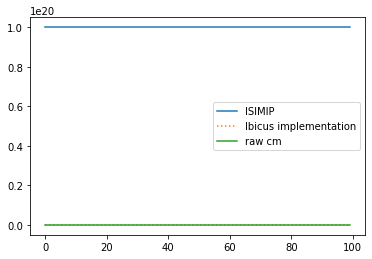

In [33]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against the Ibicus ones:

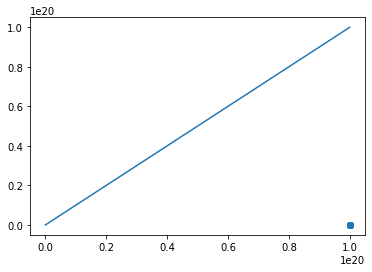

In [34]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

A linear regression also shows that the reference implementation values' and the Ibicus ones are consistent:

In [35]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**ibicus can reproduce tasrange well. Some differences larger than floating point error exist. This is due to:**

- Randomization: tasrange includes some randomization between bound and threshold. This can lead to differences.

- The references implementation of nonparametric quantile mapping (preceding the parametric one in step 6), which uses linear interpolation, is inexact and differs from the Ibicus ones. This creates some differences. These decrease with the number of quantiles increasing, however they are slightly bigger than floating point error.

- Accumulation of floating point errors in calculations. Especially floating point errors in the computation of quantiles can lead to slight numerical differences (larger than floating point) if those quantiles are mapped back to values. Similarly the distribution fits in step 6 are just slightly different (within floating point accuracy), meaning that the same values are mapped to slighty different ones (with difference potentially larger than floating point error) if transformed with an (inverse) CDF.



### 2.8. tasskew <a class="anchor" id="bullet-28"></a>

Run the Ibicus ISIMIP implementation:

In [36]:
variable = "tasskew"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily near-surface air temperature skew (tas-tasmin)/tasrange -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:15<00:00,  3.80s/it]


Compare:

In [37]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.abs(debiased_values -debiased_values_isimip) < 1e-3)/debiased_values.size
max_deviation = np.max(np.abs(debiased_values-debiased_values_isimip))
print(f"{pct_agreement*100}% of all values are within 1e-3. There is a maximum deviation of {max_deviation} which is {100*max_deviation/np.mean(debiased_values_isimip)}% of the average value")

0.0% of all values are within 1e-3. There is a maximum deviation of 1.0000000200408773e+20 which is 99.99997361172842% of the average value


We can plot the values over time at location [1,1]:

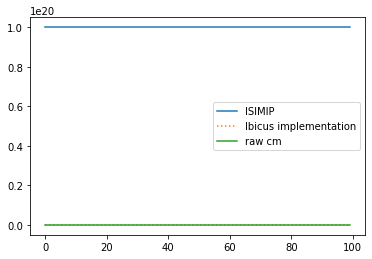

In [38]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against Ibicus ones:

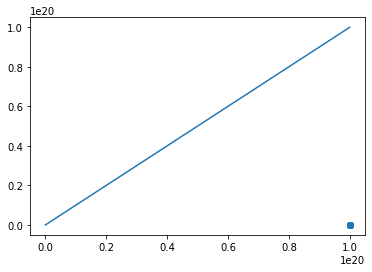

In [39]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

Linear Regression:

In [40]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**tasskew is reproduced well by ibicus. Some differences larger than floating point error exist. This is due to:**

- Randomization: tasrange includes some randomization between both upper and lower bound and threshold. This can lead to differences.

- The references implementation of nonparametric quantile mapping using linear interpolation is inexact and differs from the Ibicus ones. This creates some differences. These decrease with the number of quantiles increasing, however they are slightly bigger than floating point error.

- Accumulation of floating point errors in calculations. Especially floating point errors in the computation of quantiles can lead to slight numerical differences (larger than floating point) if those quantiles are mapped back to values. 



### 2.9. hurs <a class="anchor" id="bullet-29"></a>

Run the Ibicus ISIMIP implementation:

In [41]:
variable = "hurs"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean near-surface relative humidity -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:15<00:00,  3.80s/it]


Compare:

In [42]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.abs(debiased_values -debiased_values_isimip) < 1e-2)/debiased_values.size
max_deviation = np.max(np.abs(debiased_values-debiased_values_isimip))
print(f"{pct_agreement*100}% of all values are within 1e-2 with a maximum deviation of {max_deviation} which is {np.round(100*max_deviation/np.mean(debiased_values_isimip), 4)}% of the average value")

0.0% of all values are within 1e-2 with a maximum deviation of 1.0000000200408773e+20 which is 100.0% of the average value


We can plot the values over time at location [1,1]:

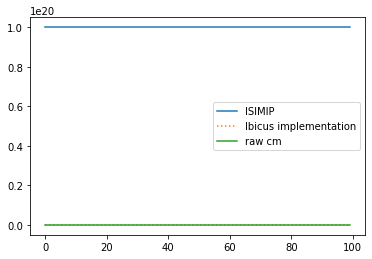

In [43]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against Ibicus ones:

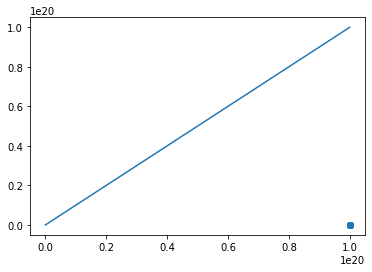

In [44]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

Linear Regression:

In [45]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**hurs is reproduced well by Ibicus. Some differences larger than floating point error exist. This is due to:**

- Randomization: as other variables hurs includes some randomization between both upper and lower bound and threshold. This can lead to differences.

- The references implementation of nonparametric quantile mapping, which uses linear interpolation, is inexact and differs from the Ibicus ones. This creates some differences. These decrease with the number of quantiles increasing, however they are slightly bigger than floating point error.

- Accumulation of floating point errors in calculations. Especially floating point errors in the computation of quantiles can lead to slight numerical differences (larger than floating point) if those quantiles are mapped back to values. 



### 2.10. rsds <a class="anchor" id="bullet-210"></a>

Run the Ibicus ISIMIP implementation:

In [46]:
variable = "rsds"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean surface downwelling shortwave radiation -----
INFO:root:obs is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_hist is a masked array, but contains no invalid data. It is converted to a normal numpy array.
INFO:root:cm_future is a masked array, but contains no invalid data. It is converted to a normal numpy array.
100%|███████████████████████████████████████████████| 4/4 [00:15<00:00,  3.92s/it]


Compare:

In [47]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.abs(debiased_values -debiased_values_isimip) < 0.1)/debiased_values.size
max_deviation = np.max(np.abs(debiased_values-debiased_values_isimip))
print(f"{pct_agreement*100}% of all values are within 0.1 with a maximum deviation of {max_deviation} which is {100*max_deviation/np.mean(debiased_values_isimip)}% of the average value")

0.0% of all values are within 0.1 with a maximum deviation of 1.0000000200408773e+20 which is 99.99997361172842% of the average value


We can plot the values over time at location [1,1]:

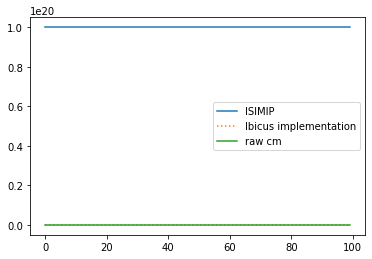

In [48]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against ibicus ones:

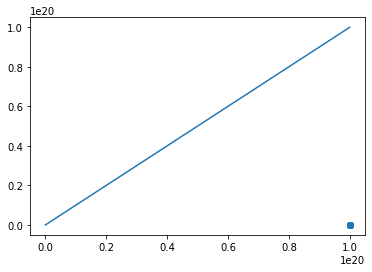

In [49]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

Linear Regression:

In [50]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

**ibicus reproduces rsds well. Some differences larger than floating point error exist. This is due to:**

- Randomization: rsds includes some randomization between both upper and lower bound and threshold. This can lead to differences.

- The references implementation of nonparametric quantile mapping, which uses linear interpolation, is inexact and differs from the Ibicus ones. This creates some differences. These decrease with the number of quantiles increasing, however they are slightly bigger than floating point error.

- Accumulation of floating point errors in calculations. Especially floating point errors in the computation of quantiles can lead to slight numerical differences (larger than floating point) if those quantiles are mapped back to values. 



### 2.11. prsnratio <a class="anchor" id="bullet-211"></a>

Run the Ibicus ISIMIP implementation:

In [51]:
variable = "prsnratio"
obs, cm_hist, cm_future, dates = read_in_and_preprocess_isimip_testing_data_with_dates(variable)
debiaser = ISIMIP.from_variable(variable)
debiased_values = debiaser.apply(obs, cm_hist, cm_future, **dates)

INFO:root:----- Running debiasing for variable: Daily mean snowfall flux / Daily mean precipitation -----
100%|███████████████████████████████████████████████| 4/4 [00:07<00:00,  1.93s/it]


Compare:

In [52]:
debiased_values_isimip = read_in_debiased_testing_data(variable)
pct_agreement = np.sum(np.isclose(debiased_values,debiased_values_isimip))/debiased_values.size
max_deviation = np.max(np.abs(debiased_values-debiased_values_isimip))
print("Percentage agreement is %s with max deviation %s"%(pct_agreement*100, max_deviation))

Percentage agreement is 0.0 with max deviation 1e+20


We can plot the values over time at location [1,1]:

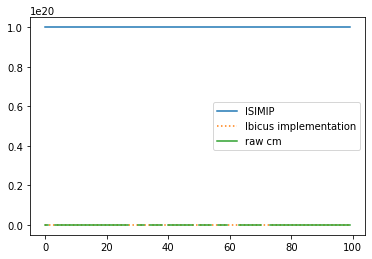

In [53]:
min_time = 0
max_time = 100
lat = 1
lon = 1
time = np.arange(min_time, max_time)

plt.plot(time, debiased_values_isimip[min_time:max_time, lat, lon], label = "ISIMIP")
plt.plot(time, debiased_values[min_time:max_time, lat, lon], label = "Ibicus implementation", linestyle = ":")
plt.plot(time, cm_future[min_time:max_time, lat, lon], label = "raw cm")
plt.legend()
plt.show()

Values of reference implementation against Ibicus ones:

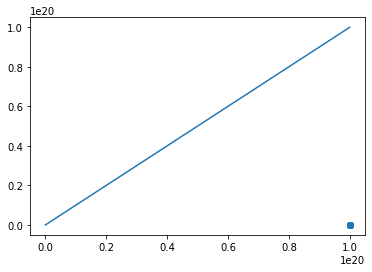

In [54]:
min_all_values = np.min([np.min(debiased_values), np.min(debiased_values_isimip)])
max_all_values = np.max([np.max(debiased_values), np.max(debiased_values_isimip)])

plt.scatter(debiased_values_isimip.flatten(), debiased_values.flatten())
plt.plot([min_all_values, max_all_values], [min_all_values, max_all_values])
plt.show()

Linear Regression:

In [55]:
scipy.stats.linregress(debiased_values_isimip.flatten(), debiased_values.flatten())

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=nan, intercept=nan, rvalue=0.0, pvalue=1.0, stderr=inf, intercept_stderr=inf)

prsnratio includes a large amount of randomization: the metric is not defined on any day without rain (given that it is the ratio of prsn over pr) and in step 2 of the ISIMIP algorithm these values where the metric is not defined are filled with draws from all other available values in a given window (in all three: obs, cm_hist, cm_future). This randomization and random draws are not exactly reproducible using Ibicus and they influence all other computed values: the transfer of the climate change signal in step 5, the computation which values are set to bounds and the nonparametric quantile mapping in step 6. However the values of Ibicus and the reference implementation nevertheless seem in decent agreement and special care was taken to ensure that the outputs of all steps not including randomzation do agree.

## 3. Summary <a class="anchor" id="bullet-3"></a>



The results of the ibicus and reference implementation of ISIMIP agree. Some smaller differences do exist -- at points slightly larger than floating point error, in particular for variables that involve randomization. However, these differences are within the small numerical differences that are to be expected in two different implementations of an algorithm involving a large variety of steps.

The results above also only serve as last "sanity check" and demonstration for the ibicus implementation of ISIMIP. The authors of the software package took special care that the results do also agree in all intermediate steps. Differences seen in the outputs here were therefore shown to be due to the differences named above (in the variables).